In [1]:
from metrics import (
    SquaredError, 
    MeanSquaredError,
    FunctionClassError,
)
from metrics.utils import post_process

from interactive import load_checkpoint_with_config

from function_classes import (
    FunctionClass,
)

import matplotlib.pyplot as plt
import torch

from typing import NamedTuple
from pathlib import Path

from parse import process_config_from_file
from utils import get_latest_checkpoint_path_from_dir

In [2]:
class ModelLoadSpecs(NamedTuple):
    name: str
    checkpoint_dir: Path

parent_checkpoint_dir = Path().resolve().parent / "models"

model_load_specs: list[ModelLoadSpecs] = [ModelLoadSpecs(name='Base_Model', checkpoint_dir=parent_checkpoint_dir / "poly_base_model"), 
                                          ModelLoadSpecs(name='Lora_Finetune', checkpoint_dir=parent_checkpoint_dir / "poly_lora_model"),
                                          ModelLoadSpecs(name='Soft_Model', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_model")]


In [3]:
processed_config, parsed_config = process_config_from_file(filename=str(model_load_specs[0].checkpoint_dir / "config.yml"),
                                                           include=None,
                                                           checkpoint_path=str(get_latest_checkpoint_path_from_dir(model_load_specs[0].checkpoint_dir)))

base_fc: FunctionClass = processed_config['function_classes'][-1] # Choose the last function class from curriculum
del processed_config # Make sure we don't use all memory on having a model in memory

METRIC = SquaredError()
NUM_BATCHES, B_SIZE = 1024, 64
SEQ_LEN = base_fc.x_dist.batch_shape[1]
X_DIM = parsed_config['x_dim']
Y_DIM = parsed_config['y_dim']
X_SHAPE = torch.Size([B_SIZE, SEQ_LEN, X_DIM])
Y_SHAPE = torch.Size([B_SIZE, SEQ_LEN, Y_DIM])

bench = FunctionClassError(METRIC, function_class=base_fc)

Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters


In [4]:

MODELS = {
    load_specs.name: load_checkpoint_with_config(str(load_specs.checkpoint_dir / "config.yml"), 
                                                 str(get_latest_checkpoint_path_from_dir(load_specs.checkpoint_dir)), 
                                                 import_configs=False)
    for load_specs in model_load_specs
    # RetrievalDictModel(x_dim=X_DIM, y_dim=Y_DIM),
    # ZeroModel(x_dim=X_DIM, y_dim=Y_DIM),
    # LeastSquaresModel(x_dim=X_DIM, y_dim=Y_DIM),
    # LassoModel(alpha=0.001, x_dim=X_DIM, y_dim=Y_DIM),
}

Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
LoraGPT2Model trainable parameters: 12288
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800


In [5]:
errs = bench.evaluate(MODELS.values(), num_batches=100)
values = list(post_process(errs))

Device: cuda:0 cuda:0
Device: cuda:0
Device: cuda:0 cuda:0
Device: cuda:0
Device: cuda:0 cuda:0
Device: cuda:0


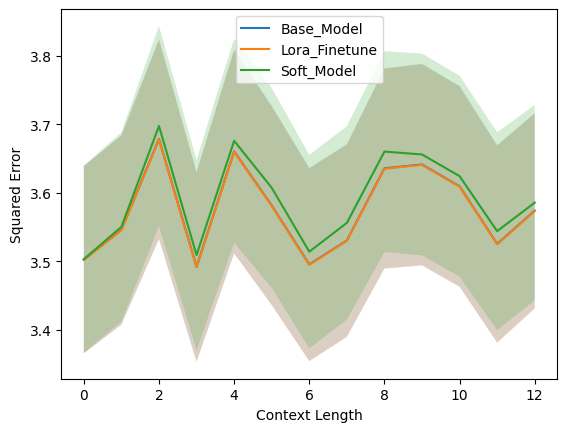

In [6]:
for name, results in zip(MODELS.keys(), values):
    plt.plot("accuracy", data=results, label=f"{name}")
    plt.fill_between(range(SEQ_LEN), results["confidence_0.05_lower"][:, 0], results["confidence_0.05_upper"][:, 0], alpha=0.2)

plt.ylabel(f"Squared Error")
plt.xlabel(f"Context Length")
plt.legend()
plt.show()